<a href="https://colab.research.google.com/github/soyudea/StrokePredictionModel/blob/main/03_modelo_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import math
from seaborn import distplot
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error, r2_score, mean_squared_error
from matplotlib.patches import split_path_inout
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot
from sklearn.svm import SVC
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

**Carga del dataset**  https://www.kaggle.com/competitions/playground-series-s3e2/data?select=train.csv

In [ ]:
#Se carga dataset obtenido de Kaggle de competencia
#==============================================================
datos = pd.read_csv('train.csv', sep=",")
datos_test = pd.read_csv('test.csv', sep=",")
df =datos.copy()
df_test=datos_test.copy()

**Se agregan valores nulos al 5 % de las muestras en los campos age, avg_glucose_level**

In [ ]:
#Se adiciona valores nulos al atributo age y avg_glucose_level
#=============================================================
#df =datos.copy()
lista=[]
porc_nulos =int(np.shape(df)[0]*5/100)   #Calculo de porcentaje de datos nulos
rango_df = np.shape(df)[0]

for i in range(porc_nulos):
    num_aleatprio = np.random.randint(rango_df) 
    lista.append(num_aleatprio)


for i in lista:
    df.at[i, "age"] = np.nan

lista=[]
rango_df = np.shape(df)[0]

for i in range(porc_nulos):
    num_aleatprio = np.random.randint(rango_df) 
    lista.append(num_aleatprio)


for i in lista:
    df.at[i, "avg_glucose_level"] = np.nan

**Estado del dataset despues de agregar valores nulos**

In [ ]:
df.isna().sum().sort_values()

id                     0
gender                 0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
bmi                    0
smoking_status         0
stroke                 0
avg_glucose_level    737
age                  747
dtype: int64

**Se agregan valores promedios en aquellas muestras con valores nulos**

In [ ]:
#Se agregan valores promedios al atributo age cuando son nulos
#==================================================================

mean_age = df['age'].mean().astype(int) #Calculo media de las edades

for i in range(len(df)):
    if math. isnan(df.at[i, "age"]):
       df.at[i, "age"] = mean_age

In [ ]:
#Se agrega valores promedios al atributo avg_glucose_level cuando son nulos
#===============================================================================================
mean_avg_glucose_level = df['avg_glucose_level'].mean().astype(int) #Calculo media de las edades

for i in range(len(df)):
    if math. isnan(df.at[i, "avg_glucose_level"]):
       df.at[i, "avg_glucose_level"] = mean_avg_glucose_level

**Estado final del dataset despues de reemplazar valores nulos con valores promedios**

In [ ]:
datos['age'] = datos['age'].astype('int64') 
datos.info()

In [ ]:
df.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

**Discretización de las variables 'age', 'avge_glucose_level', 'bmi'**

In [ ]:
#Se transforma campo numerico age a un atributo con valores categoricos, se discretisa
#========================================================================================================================================================

df = datos.copy()

edades = pd.cut(df['age'], bins = [0,10,20,40,np.inf], labels =['niño','joven','adulto','mayor'], include_lowest=True, retbins = True)
df['new_age'] = list(edades[0]) 

glucosa = pd.cut(df['avg_glucose_level'], bins = [0,100,125,np.inf], labels = ['normal', 'prediabetico','diabetico'], include_lowest=True, retbins=True)
df["avg_glucose"] = list(glucosa[0])

im = pd.cut(df['bmi'], bins = [18.5,24.9,25,29.9,np.inf], labels = ['low_weight', 'Healthy_weight','overweight','obesity'], include_lowest=True, retbins=True)
df['bmi_range'] = list(im[0])
df.shape

(15304, 15)

**Transformación del dataset, de variables categoricas a númericas**

In [ ]:
#Se obtiene un dataset con todos sus atributos numéricos
#========================================================================================================================================================================================================================================
vnumericas = df.drop(["id","avg_glucose_level","age","bmi","new_age","avg_glucose","bmi_range","gender","ever_married","work_type","Residence_type","smoking_status", "bmi_range"],axis=1)#SE crea variable númerica sin las categoricas 
vcategoricas=df.filter(["new_age","avg_glucose","bmi_range","gender","ever_married","work_type","Residence_type","smoking_status", "bmi_range"]) 

cat_numerica=pd.get_dummies(vcategoricas,drop_first=False) 
df=pd.concat([cat_numerica,vnumericas],axis=1)
#datos = df
df.shape

(15304, 34)

**Organización del dataset final**

In [ ]:
X = df[:len(df)]
y = df['stroke']
X = X.drop(columns=['stroke'])
X.columns
X.shape

(15304, 33)

**Generador de muestras sintéticas**

In [ ]:
pca=PCA(n_components=30) 
pca.fit(X) #
X_pca=pca.transform(X)

In [ ]:
ros = RandomOverSampler(random_state=42, sampling_strategy=1.0)                          
Xres, yres = ros.fit_resample(X_pca, y)
Xtrain, Xtst, ytrain, ytst = train_test_split(Xres,yres, test_size=0.1) #Se toma el 90 % de los datos para Entrenar
print (Xtrain.shape, ytrain.shape, Xtst.shape, ytst.shape)
X=Xtrain
y=ytrain

(26409, 30) (26409,) (2935, 30) (2935,)


**Calculo pesos de la clase Parametro que se usa para minimizar el efecto del desbalance del dataset**

In [ ]:
def dar_peso_clase():
  Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2, train_size = 0.8, random_state = 17)
  Number_Muestras_por_Clase = ytrain.value_counts()
  Number_Muestras_por_Clase = Number_Muestras_por_Clase.sort_index(axis = 0, ascending = True)
  Numero_de_Clases = len(Number_Muestras_por_Clase.index)
  Peso_por_Clase = len(ytrain)/(Numero_de_Clases*Number_Muestras_por_Clase)
  return Peso_por_Clase

**Maquina de soporte vectorial** https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

**Calculo de parametros**

In [ ]:
from sklearn.utils.fixes import loguniform
param_grid = {'kernel': ['rbf'], 'C':[1, 10, 20],
              'gamma': [1e-3, 1e-4] ,
              
              } 
#'tol':[1e-3, 1e-4],           
#  'decision_function_shape':['ovo', 'ovr']

svc = svm.SVC(gamma="scale")
clf = GridSearchCV(svc, param_grid, cv=5,n_jobs=2)
clf.fit(X, y) 
parametros = pd.concat([pd.DataFrame(clf.cv_results_["params"]),
                pd.DataFrame(clf.cv_results_["mean_test_score"],
                columns=["Accuracy"])],axis=1)
print(parametros)

    C   gamma kernel  Accuracy
0   1  0.0010    rbf  0.729259
1   1  0.0001    rbf  0.722519
2  10  0.0010    rbf  0.729259
3  10  0.0001    rbf  0.729259
4  20  0.0010    rbf  0.729259
5  20  0.0001    rbf  0.729259


In [ ]:
kf = KFold(n_splits=5, random_state = True,shuffle=True)
c=1
weight= dar_peso_clase()
X_test =0
y_test =0
#degree =3 los resultados fueron regulares con el kernel ="poly" , no calcula area AUC

svclassifier = SVC(C=c,kernel="rbf", degree=3, gamma='auto',shrinking=True,tol=0.00010,
                   class_weight = {0: weight[0], 1: weight[1]},
                   decision_function_shape='ovr')

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    modelo = svclassifier.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    print()
    
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, digits =6, labels=[0,1],zero_division=1))
    s = roc_auc_score(y_test, modelo.predict(X_test))
    print(f'Best val auc: {s: .4f}')
    print()


[[1293 1324]
 [  47 2618]]
              precision    recall  f1-score   support

           0   0.964925  0.494077  0.653525      2617
           1   0.664130  0.982364  0.792493      2665

    accuracy                       0.740439      5282
   macro avg   0.814528  0.738221  0.723009      5282
weighted avg   0.813161  0.740439  0.723641      5282

Best val auc:  0.7382


[[1191 1415]
 [  54 2622]]
              precision    recall  f1-score   support

           0   0.956627  0.457022  0.618541      2606
           1   0.649492  0.979821  0.781171      2676

    accuracy                       0.721886      5282
   macro avg   0.803059  0.718421  0.699856      5282
weighted avg   0.801024  0.721886  0.700933      5282

Best val auc:  0.7184


[[1242 1364]
 [  66 2610]]
              precision    recall  f1-score   support

           0   0.949541  0.476592  0.634645      2606
           1   0.656769  0.975336  0.784962      2676

    accuracy                       0.729269      528

**Curva ROC Modelo maquina de soporte Vectorial SVC**


Average_presicion_score 0.4911948494603295
Sin entrenar: ROC AUC=0.500
Algoritmo SVC: ROC AUC=0.731



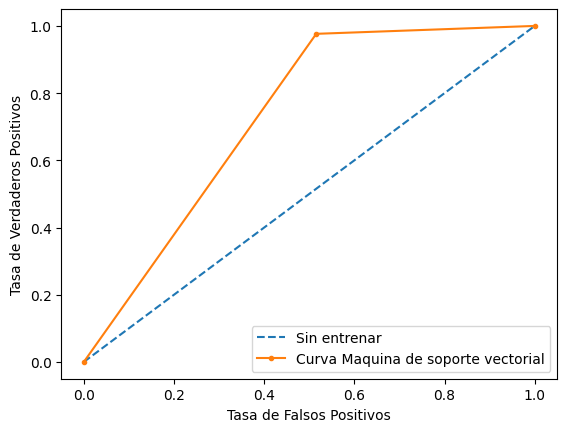

In [ ]:
#Curva ROC
classes = svclassifier.predict(X_test)
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs,average='weighted')
svclassifier_auc = roc_auc_score(y_test,classes,average='weighted')
aps = average_precision_score(y_test, ns_probs)

print("Average_presicion_score "+str(aps))
print('Sin entrenar: ROC AUC=%.3f' % (ns_auc))
print('Algoritmo SVC: ROC AUC=%.3f' % (svclassifier_auc))
svclassifier_probs = classes[:]
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Sin entrenar')
svclassifier_fpr, classifier_tpr, _ = roc_curve(y_test, svclassifier_probs)
print()
pyplot.plot(svclassifier_fpr, classifier_tpr, marker='.', label='Curva Maquina de soporte vectorial')
pyplot.xlabel('Tasa de Falsos Positivos')
pyplot.ylabel('Tasa de Verdaderos Positivos')
pyplot.legend()
pyplot.show()
print()